# All kinds of network things 

In [1]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import regex as re 
from os import listdir
from os.path import isfile, join
import json 
# get files in directory 
onlyfiles = [f for f in listdir("wiki_content") if isfile(join("wiki_content", f))]

In [2]:
''' Extract links '''
theo_dict  = {}
for file in onlyfiles:
    with open(f'wiki_content/{file}','r', encoding = 'utf-8') as f:
        txt = f.read()
        links = re.findall('\[\[(.*?)(?:\|.*?)?]]', txt)
        name = file.split('.txt')[0].replace('_',' ')
        theo_dict.update({name:links}) 

In [3]:
''' Hvordan linker de til hinanden '''
# Sætter .replace('_', ' ') på name, for at have styr på fx 'Anselm_Strauss' links 
link_dict = {theorist:[_name.replace('_', ' ') for _name in links if _name.replace('_', ' ') in theo_dict.keys()]\
             for theorist, links in theo_dict.items()}

''' Link list '''
link_list = [(node_a, node_b) for node_a, nodes in link_dict.items() for node_b in nodes]


''' Save the data '''
with open("edge_list.json", "w") as f:
    json.dump(link_list, f)
    
with open("node_list.json", "w") as f:
    json.dump(list(link_dict.keys()), f)    

In [4]:
''' Get science attribute '''

with open('science_name_dict.json', 'r', encoding = 'utf-8') as f: 
    science_dict = json.load(f)

# Rename keys 
for new, old in zip(['Economist', 'Sociologist', 'Anthropologist', 'Political Scientist', 'Psychologist'],
                ['eco', 'soc', 'anth', 'pol', 'psy']):

    science_dict[new] = science_dict.pop(old) # new keys 

''' Get those that are in multiple scientific field lists - Marx is in both... '''

socs = set(science_dict['Sociologist'])
anths = set(science_dict['Anthropologist'])
ecos = set(science_dict['Economist'])
psys = set(science_dict['Psychologist'])
pols = set(science_dict['Political Scientist'])

seen = []
repeated = []
for l in [socs, anths, ecos, psys, pols]:
    for i in l: # loop over de enkelte guys'n'gals
        if i in seen:
            repeated.append(i)
        else:
            seen.append(i)

''' Inverse the dict '''
inv_science_dict = {name:science for science, names in science_dict.items() for name in names}
''' change the scientific field to "both" if they are both in the soc and anth list '''
inv_science_dict = {name:('Multiple' if name in repeated else sci)\
                    for name, sci in inv_science_dict.items()}

# Match keys to link_dict --> when importing link_dict, 'Anselm_Strauss' becomes 'Anselm Strauss'
# but in the inv_science_dict he is 'Anselm_Strauss'. So it is a mess without it   
inv_science_dict = {key.replace('_', ' '):val for key, val in inv_science_dict.items()}

with open('inv_science_name_dict.json', 'w', encoding = 'utf-8') as f: 
    json.dump(inv_science_dict, f)

In [5]:
''' Make network '''
import networkx as nx
import netwulf as nw
G = nx.DiGraph()
G.add_nodes_from(link_dict.keys())
G.add_edges_from(link_list)
nx.set_node_attributes(G, inv_science_dict, name = 'group') # node attributes 

In [7]:
''' Plot network '''
import matplotlib.pylab as plt
%matplotlib inline
plt.style.use('seaborn-white')

network, config = nw.visualize(G, plot_in_cell_below=False)

In [17]:
''' Plot network '''
import matplotlib.pylab as plt
%matplotlib inline
plt.style.use('seaborn-white')

''' Recolor nodes based on a partition dictionary and colormap 
    Only works if all nodes in nx_configs are in partition_dict as well '''

def redefine_attr(nx_configs, partition_dict, _sort = False ,_cmap = plt.cm.Spectral_r):
    import copy
    import matplotlib
    ''' Using The sort parameter, you can reference at dict to sort the attributes by,
    where the dicts keys is the attribute, and the dicts value represents some order '''
    
    if _sort:
        _keys = sorted(set(partition_dict.values()), key = lambda x: _sort[x], reverse = True)
    else:
        _keys = set(partition_dict.values()) # the attribute classes
        
    n_keys = len(_keys) # how many are there? how many colors do we need?
    # assign each attribute class a unique value between 0 and 1
    # _num/(n_keys-1) --> standarize score with 0 and 1 as min and max
    attr_scale_dict = {_cat:_num/(n_keys-1) for _cat, _num in zip(_keys, range(n_keys))}
    
    # Copy dict - deep copy as the values are nested in a list
    new_nw = copy.deepcopy(nx_configs)
    
    for node_nr in range(len(nx_configs['nodes'])):
        node = nx_configs['nodes'][node_nr]['id'] # node id 
        attr = partition_dict[node] # get the attribute class of the node
        num_attr = attr_scale_dict[attr] # get the numerical 
        _cmap_color = _cmap(num_attr)
        # overwrite node color based on new attr
        new_nw['nodes'][node_nr]['color'] = matplotlib.colors.rgb2hex(_cmap_color) 
        
    return new_nw


In [ ]:
# set colormap of the plot 
network = redefine_attr(network, sort_dict(inv_science_dict))

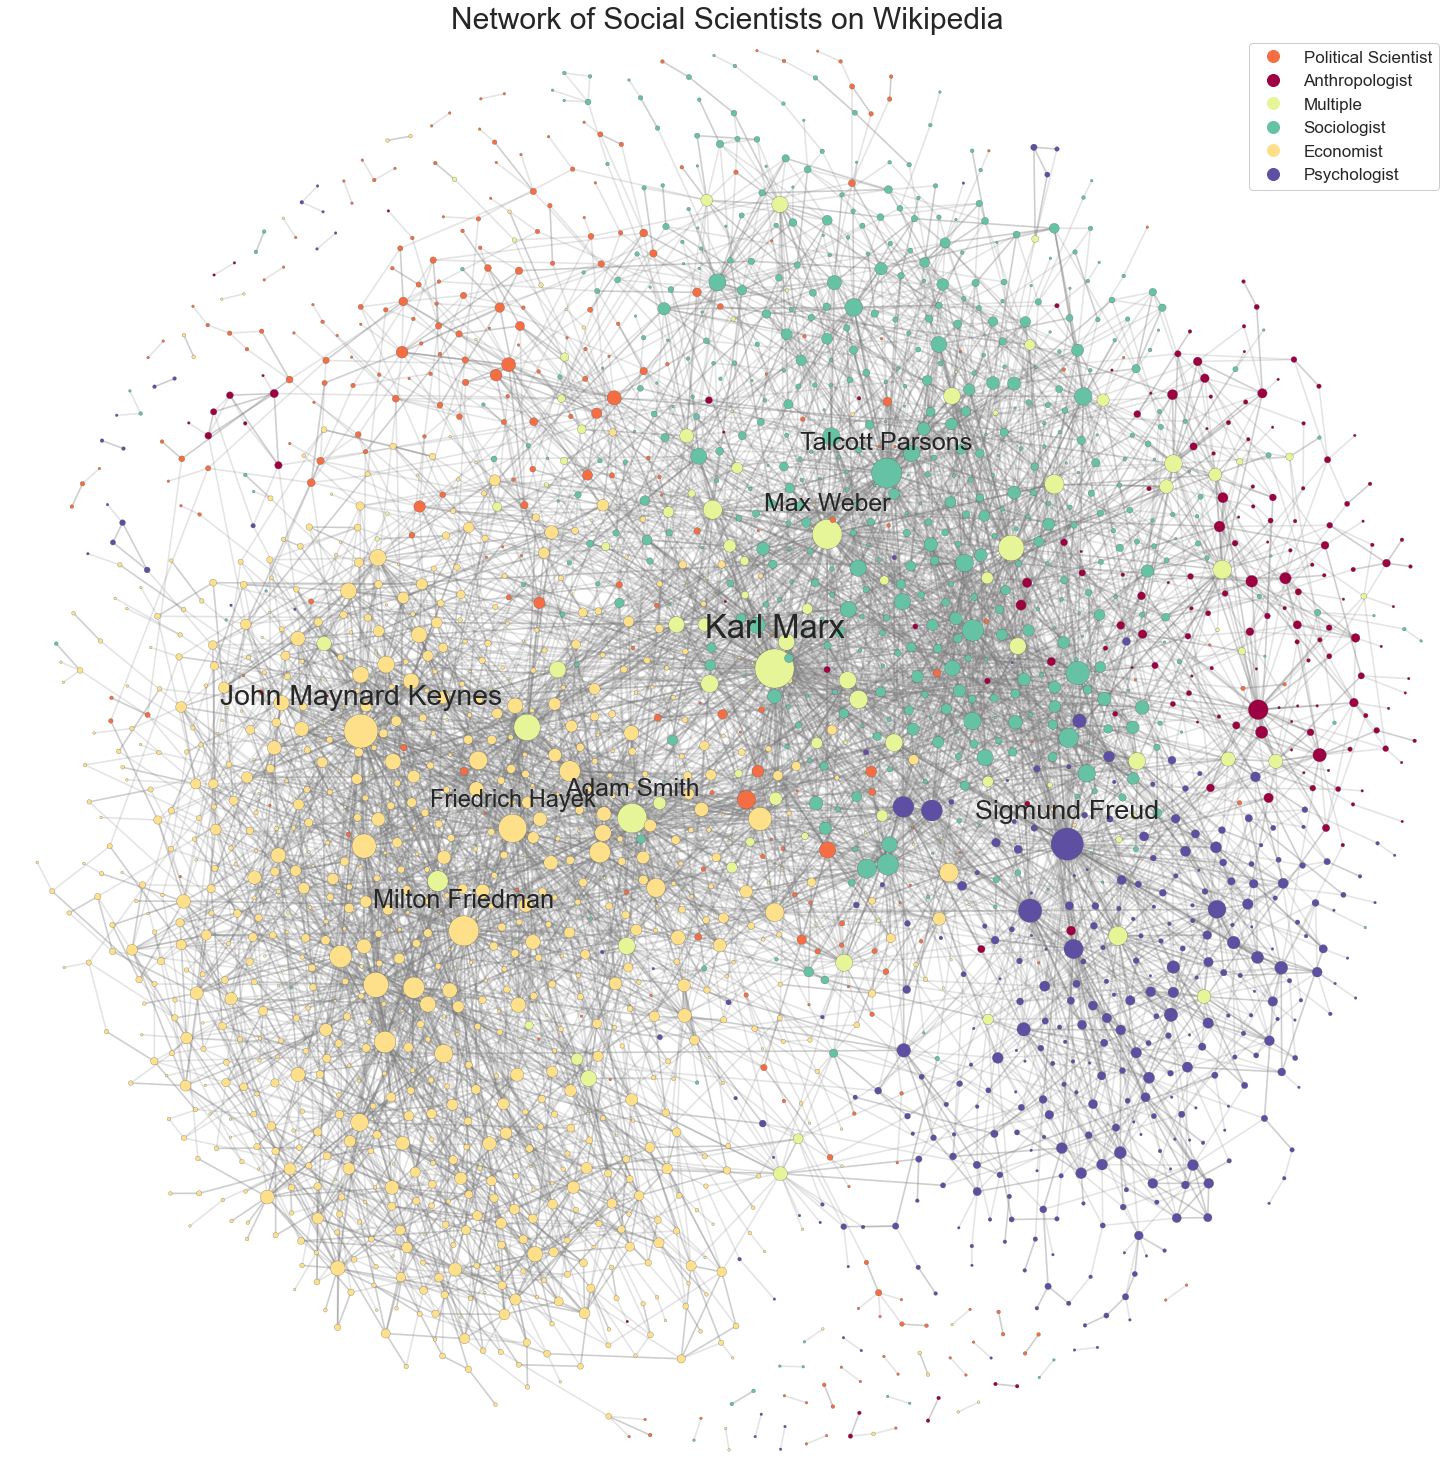

In [20]:
# Drawing a big figure
plt.rcParams["figure.figsize"] = (20,20)

# Drawing the network
fig, ax = nw.draw_netwulf(network)

# assigning labels only to the largest nodes 
for node_nr in range(len(network['nodes'])):
    if network['nodes'][node_nr]['radius']>7.5:
        nw.tools.add_node_label(ax,
                                network,
                                dy = network['nodes'][node_nr]['radius']*2,
                                node_id = network['nodes'][node_nr]['id'],
                                size=network['nodes'][node_nr]['radius']*3)
    else:
        pass


val_map = {inv_science_dict[node['id']]:node['color'] for node in network['nodes']}

# Add legends
for label in val_map.keys():
    ax.plot([],[],color=val_map[label], label=label, marker='o', linestyle="None", markersize = 12)

plt.legend(fontsize = 17, frameon=True, framealpha=1)

ax.set_title('Network of Social Scientists on Wikipedia', size = 30)
# Saving as pdf
plt.savefig('Plots/field_network_title.png', dpi=None, facecolor='w', edgecolor='w', bbox_inches='tight')

In [189]:
''' Save the network configurations '''
with open("network_configurations/big_network.json", 'w') as f:
    json.dump(network, f)
    
with open("network_configurations/big_config.json", 'w') as f:
    json.dump(config, f)

In [11]:
''' load the network configurations '''
with open("network_configurations/big_network.json", 'r') as f:
    network = json.load(f)

with open("network_configurations/big_config.json", 'r') as f:
    config = json.load(f)

In [6]:
import matplotlib.pylab as plt
%matplotlib inline
plt.style.use('seaborn-white')

''' Degree distribution '''
def plot_deg_dist(deg_seq, title = 'Degree distribution', save = False, save_title = "", kwgs = {}):
    plt.style.use('ggplot')
    
    fig, ax = plt.subplots(2,1, figsize=(10,8))
    
    sns.scatterplot(x=deg_seq.keys(), y=deg_seq.values(), ax = ax[0], **kwgs)
    ax[0].set_title(title)
    ax[0].set_ylabel('Frequency', size = 15)
    
    del deg_seq[0] # messes up the log plot so remove 0 deg nodes 
    sns.scatterplot(x=deg_seq.keys(), y=deg_seq.values(), ax = ax[1], **kwgs)

    ax[1].set_title(title + ' (log scaled)')
    ax[1].set_ylabel('Frequency', size = 15)
    ax[1].set_xlabel('k', size = 15)
    # logscale the axes
    ax[1].set_yscale('log')
    ax[1].set_xscale('log')
    
    # Saving as pdf
    plt.savefig(f'Plots/{save_title}.png', dpi=200, facecolor='w', edgecolor='w', bbox_inches='tight')
    plt.show()

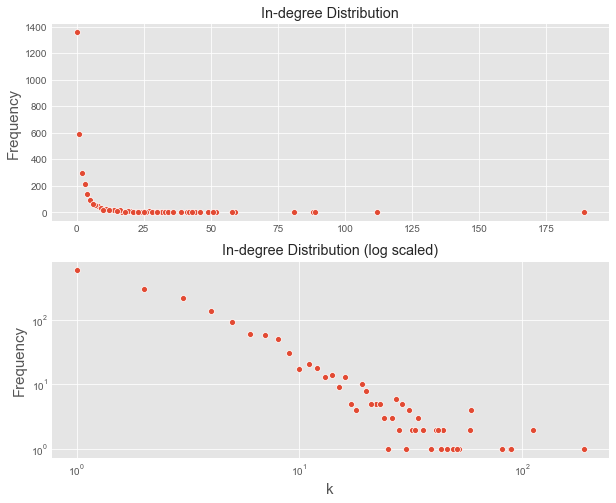

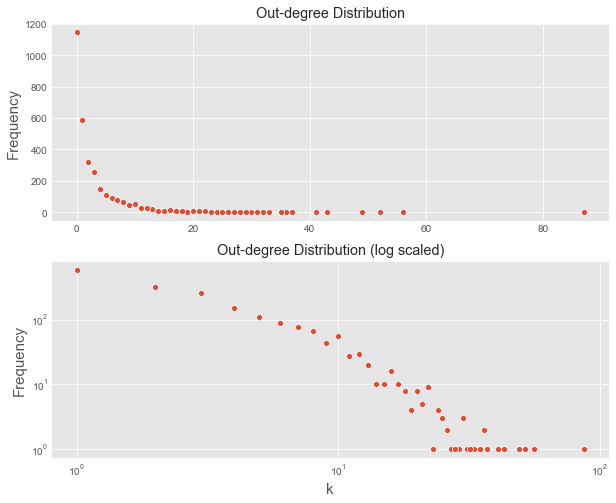

In [7]:
''' Plot degree distribution '''
import seaborn as sns
from collections import Counter

# Get in and out degree
in_deg_dist = Counter([d for n,d in G.in_degree()])
out_deg_dist = Counter([d for n,d in G.out_degree()])

# Plot and save 
plot_deg_dist(in_deg_dist, 'In-degree Distribution', save = True,save_title="in_deg_dist")
plot_deg_dist(out_deg_dist, 'Out-degree Distribution', save = True,save_title= "out_deg_dist")

In [9]:
import powerlaw

# list of degrees
deg_in = [_ for _key, _ in dict(G.in_degree()).items()]
deg_out = [_ for _key, _ in dict(G.out_degree()).items()]
# Calc exponent
print('Degree exponent for in-degrees:', powerlaw.Fit(deg_in, verbose = False).alpha)
print('Degree exponent for out-degrees:', powerlaw.Fit(deg_out, verbose = False).alpha)

Degree exponent for in-degrees: 2.5693308119051164
Degree exponent for out-degrees: 4.403722203175794


In the previous exercise, we speculated that the in-degree distribution appeared to be scale-free. Based on the degree exponent, we now see that this is not the case. Both the degree exponent of the in- and out-degree distribution are $\gamma$ > 3, which means that they are not in the scale free region, where $2<\gamma<3$. Rather, they are both (barely) in the random network regimes (Barabassi section 4.7). 

In [193]:
''' Plot the top X out- and in- degree nodes '''
def plot_top_nodes(top_n = 50, in_deg = True, save = False, save_title = ""):
    if in_deg:
        top_nodes = sorted(dict(G.in_degree()).items(), key = lambda x: x[1], reverse = True)[:top_n]
    else:
        top_nodes = sorted(dict(G.out_degree()).items(), key = lambda x: x[1], reverse = True)[:top_n]
    x = [_[0] for _ in top_nodes]
    y = [_[1] for _ in top_nodes]

    fig, ax = plt.subplots(figsize = (12,6))
    sns.scatterplot(x,y, ax=ax)
    ax.set_ylabel('Degree', size = 15)
    plt.xticks(rotation=90, size = 12)
    if in_deg:
        ax.set_title(f'Distribution of in-degree for top {top_n}', size = 15)
    else:
        ax.set_title(f'Distribution of out-degree for top {top_n}', size = 15)
    
    if save:
        # Saving as pdf
        plt.savefig(f'Plots/{save_title}.png', dpi=200, facecolor='w', edgecolor='w', bbox_inches='tight')

    plt.show()

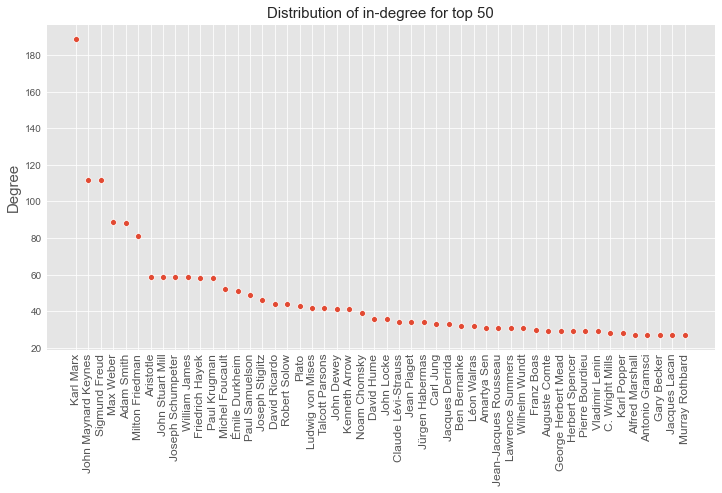

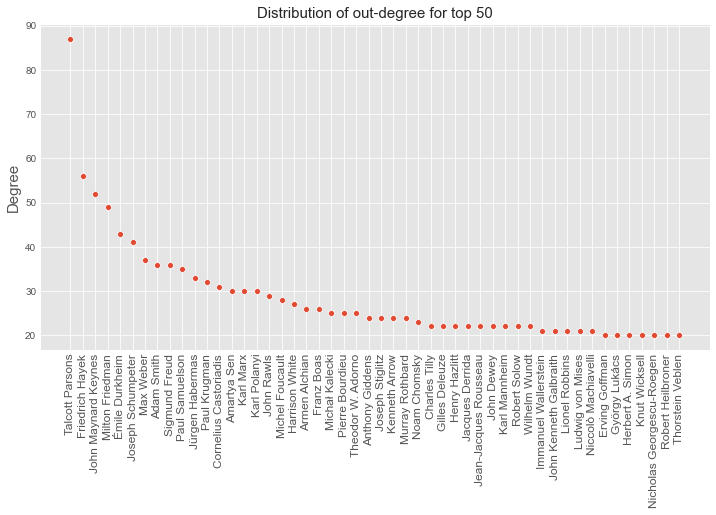

In [194]:
plot_top_nodes(in_deg = True, save=True, save_title="top_in_deg")
plot_top_nodes(in_deg = False, save=True, save_title="top_out_deg")

# Communities 

In [18]:
import community

In [19]:
''' Only the GCC, otherwise there will be about 300+ communities '''
G_c = G.copy()
c = max(nx.weakly_connected_components(G_c), key=len) # largest connected component
GCC = G_c.subgraph(c).copy() # make subgraph of the largest connected component
G_undir = GCC.to_undirected().copy() # undirected

# Louvain modularity for partition
partition = community.best_partition(G_undir, random_state = 280395)

# Community size

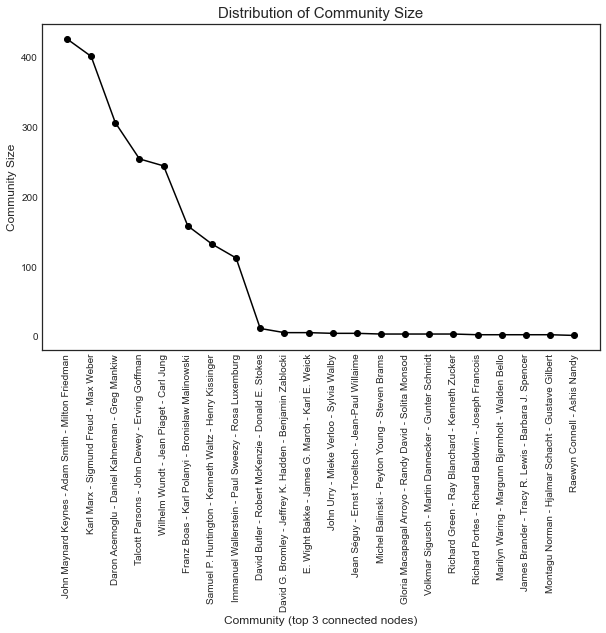

In [20]:
import matplotlib.pylab as plt
%matplotlib inline
plt.style.use('seaborn-white')

com_dict = {_com:{n for n, d in partition.items() if d == _com} for _com in range(max(partition.values())+1)}

''' Rename communities after their 3 most connected nodes '''
def sort_dict(_dict, reverse = False):
    return (dict(sorted(_dict.items(), key=lambda x: x[1], reverse = reverse)))

named_com_dict = com_dict.copy()
# loop over community and their nodes 
for _com, _nodes in com_dict.items():
    # dictionary with {node:degree}
    node_degree_dict = {node:G_undir.degree()[node] for node in _nodes}
    # sort based on degree
    node_degree_dict = sort_dict(node_degree_dict, reverse = True)
    # Get the 3 most connected
    top_3_connected = list(node_degree_dict.keys())[:3]
    # Turn the top 3 into a single string + remove the extentions of very long names link Esben, the first of the seas 
    top_3_connected = ' - '.join([str(n).split(',')[0] for n in top_3_connected])
    # remove parentheses like Sune (Social Data Scientist)
    top_3_connected = re.sub(' \(.*?\)', '', top_3_connected)
    # rename the community after the 3 most connected nodes 
    named_com_dict[top_3_connected] = named_com_dict.pop(_com)
    # Rename the community names in the partition dict
    for node in _nodes:
        partition[node] = top_3_connected

com_size_dict = {_com:len(nodes) for _com, nodes in named_com_dict.items()} # get com_size
com_size_dict = sort_dict(com_size_dict, reverse = True) # sort dict 

plt.rcParams["figure.figsize"] = (10,6)

x = list(com_size_dict.keys())
y = list(com_size_dict.values())
plt.plot(x,y, marker='o', c='black')
plt.xticks(rotation=90)
plt.xlabel('Community (top 3 connected nodes)', size = 12)
plt.ylabel('Community Size', size = 12)
plt.title('Distribution of Community Size', size = 15)
plt.savefig(f'Plots/community_size.png', dpi=200, facecolor='w', edgecolor='w', bbox_inches='tight')

In [14]:
# Dict with name as key and field and community dicts as values 
joined_dict = {name:{'field':inv_science_dict[name], 'community':com}\
               for name, com in partition.items()}

with open('name_field_community.json', 'w', encoding = 'utf-8') as f: 
    json.dump(joined_dict, f)
    
# Save com sizes for index sorting 
with open('com_size_dict.json', 'w', encoding = 'utf-8') as f: 
    json.dump(com_size_dict, f)

Text(0.73, 1.0, 'Community Detection')

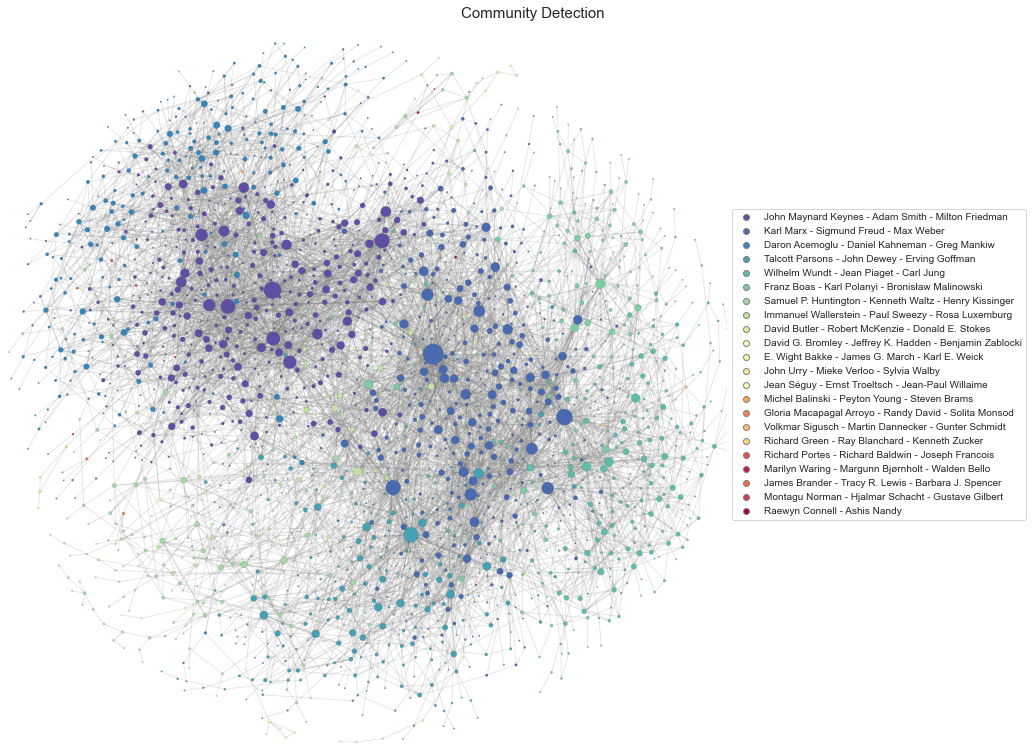

In [21]:
''' Plot community partition '''
nx.set_node_attributes(G_undir, partition, name = 'group') # node attributes 
## Use the configs from the big non-GCC network
config['zoom'] = 0.745 
network_part, config_part = nw.visualize(G_undir, plot_in_cell_below=False, config = config)
# Recolor based on Spectral colormap 
network_part = redefine_attr(network_part, partition, _sort = com_size_dict)

fig, ax = nw.draw_netwulf(network_part, figsize = 10)

# {community:color} dict for the legend
val_map = {partition[node['id']]:node['color'] for node in network_part['nodes']}

# Add legends
for v in sorted(val_map.keys()):
    plt.scatter([],[],color=val_map[v], 
                label=v, 
                marker='o',
                edgecolors= "grey",
                linestyle="None")
    
# Sort and Place legend
handles, labels = plt.gca().get_legend_handles_labels()
# Get the order of the legend - Based on community size 
order = [labels.index(_com) for _com in list(com_size_dict.keys())]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],
           bbox_to_anchor = (1,0.75), frameon=True)

# Ugly, but works 
plt.title('Community Detection', x = 0.73, size = 15)

# Saving as pdf
#fig.savefig(f'Plots/community_network.png', dpi=200, facecolor='w', edgecolor='w', bbox_inches='tight')

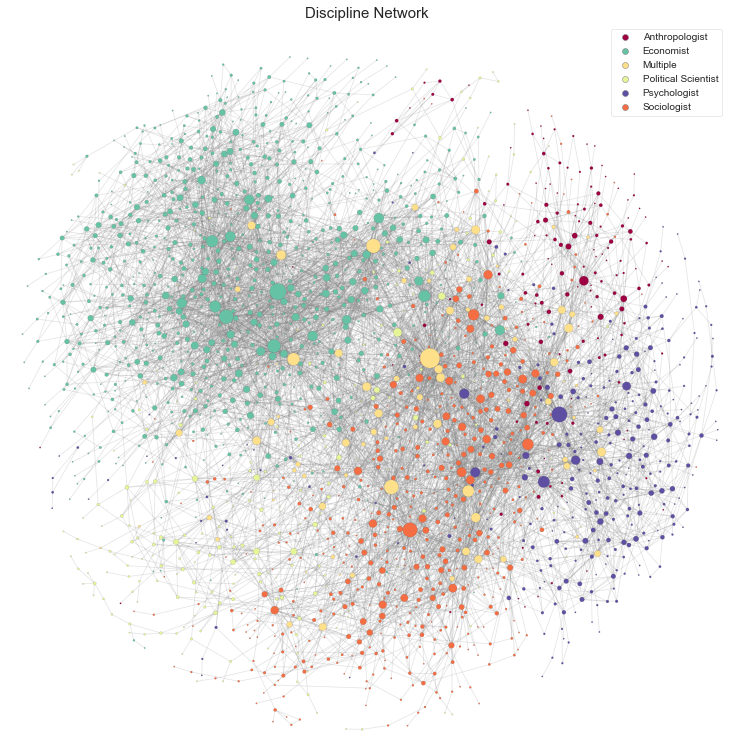

In [284]:
''' Plot community partition '''
nx.set_node_attributes(G_undir, inv_science_dict, name = 'group') # node attributes 
## Use the configs from the big non-GCC network
network_part, config_part = nw.visualize(G_undir, plot_in_cell_below=False, config = config)

# Recolor based on Spectral colormap 
network_part = redefine_attr(network_part, inv_science_dict)

fig, ax = nw.draw_netwulf(network_part, figsize = 10)

# {community:color} dict for the legend
val_map = {inv_science_dict[node['id']]:node['color'] for node in network_part['nodes']}

# Add legends
for v in sorted(val_map.keys()):
    plt.scatter([],[],color=val_map[v], 
                label=v, 
                marker='o',
                edgecolors= "grey",
                linestyle="None")
# Place legend
plt.legend(frameon=True)
plt.title('Discipline Network', size = 15)
fig.savefig(f'Plots/gcc_network.png', dpi=200, facecolor='w', edgecolor='w', bbox_inches='tight')

prøv https://github.com/beyondbeneath/bezier-curved-edges-networkx